In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import explain_prediction
from pdpbox import pdp, get_dataset, info_plots
import shap 
import lime
import lime.lime_tabular

In [46]:
# Dataset description
# This dataset consists of 13 features and a target variable.

# The detailed description of all the features are as follows:
# 1. Age: Patients Age in years (Numeric)
# 2. Sex: Gender of patient (Male - 1, Female - 0) (Nominal)
# 3. Chest Pain Type: Type of chest pain experienced by patient categorized into 1 typical, 2 typical angina, 3 non- anginal pain, 4 asymptomatic (Nominal)
#    understanding :(https://www.harringtonhospital.org/typical-and-atypical-angina-what-to-look-for/)
# 4. resting bp s: Level of blood pressure at resting mode in mm/HG (Numerical)
#    understanding :(https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained#normal) / https://www.hcs.gr/artiriaki-piesi.aspx
# 5. cholestrol: Serum cholestrol in mg/dl (Numeric)
#    understanding :(https://www.mikroviologos.gr/arthra/cholesterol)
# 6. fasting blood sugar: Blood sugar levels on fasting > 120 mg/dl represents as 1 in case of true and 0 as false (Nominal)
# 7. resting ecg: Result of electrocardiogram while at rest are represented in 3 distinct values 0 : Normal 1: Abnormality in ST-T wave 2: Left ventricular hypertrophy (Nominal)
# 8. max heart rate: Maximum heart rate achieved (Numeric)
# 9. exercise angina: Angina induced by exercise 0 depicting NO 1 depicting Yes (Nominal)
# 10. oldpeak: Exercise induced ST-depression in comparison with the state of rest (Numeric)
# 11. ST slope: ST segment measured in terms of slope during peak exercise 0: Normal 1: Upsloping 2: Flat 3: Downsloping (Nominal)
# 12. ca: The number of major vessels (0-4)
# 13. thal: A blood disorder called thalassemia (1 = normal; 2 = fixed defect; 3 = reversable defect)
#     understanding :( https://bioiatriki.gr/index.php/thalassoaimies)
# 14. target: Heart disease (0 = no, 1 = yes)

dt = pd.read_csv('heart.csv')
dt_Shape = {"Total Rows": [len(dt.index)], "Total Columns": [len(dt.columns)]}
dt_Shape = pd.DataFrame(dt_Shape,index=["Values"])
dt_Shape.transpose()

Values
Total Rows        303
Total Columns      14

In [47]:
dt.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [48]:
#Renaming features to proper names
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 
              'rest_ecg', 'max_heart_rate_achieved','exercise_induced_angina', 'st_depression', 'st_slope','major vessels', 
              'thalassemia','target']
dt.head(10)

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    1                3                     145          233   
1   37    1                2                     130          250   
2   41    0                1                     130          204   
3   56    1                1                     120          236   
4   57    0                0                     120          354   
5   57    1                0                     140          192   
6   56    0                1                     140          294   
7   44    1                1                     120          263   
8   52    1                2                     172          199   
9   57    1                2                     150          168   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                    1         0                      150   
1                    0         1                      187   
2                    0         0                      172   
3                    0         1                      178   
4                    0         1                      163   
5                    0         1                      148   
6                    0         0                      153   
7                    0         1                      173   
8                    1         1                      162   
9                    0         1                      174   

   exercise_induced_angina  st_depression  st_slope  major vessels  \
0                        0            2.3         0              0   
1                        0            3.5         0              0   
2                        0            1.4         2              0   
3                        0            0.8         2              0   
4                        1            0.6         2              0   
5                        0            0.4         1              0   
6                        0            1.3         1              0   
7                        0            0.0         2              0   
8                        0            0.5         2              0   
9                        0            1.6         2              0   

   thalassemia  target  
0            1       1  
1            2       1  
2            2       1  
3            2       1  
4            2       1  
5            1       1  
6            2       1  
7            3       1  
8            3       1  
9            2       1

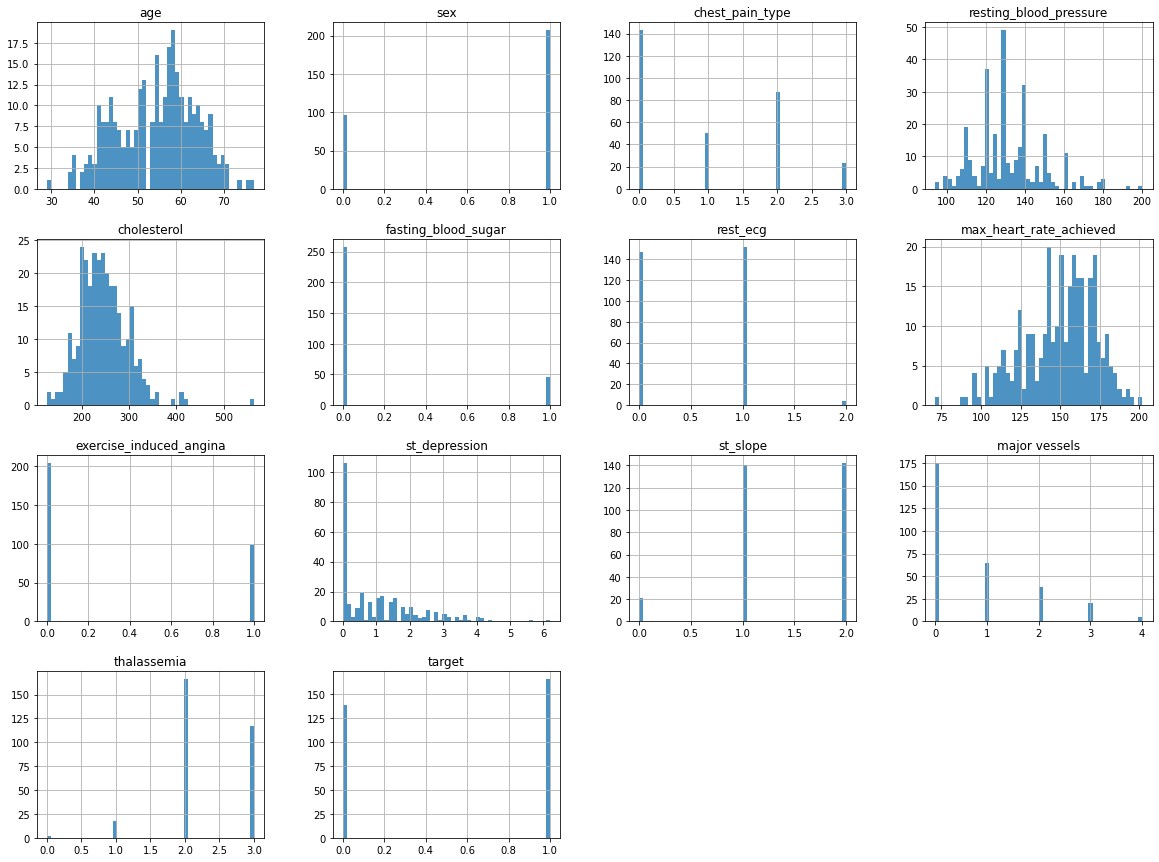

In [49]:
dt.hist(bins=50, figsize = (20,15), alpha = 0.8)
plt.show()

In [50]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 0] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 0] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 1] = 'flat'
dt['st_slope'][dt['st_slope'] == 2] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
major vessels                int64
thalassemia                 object
target                       int64
dtype: object

In [51]:
dt.shape

(303, 14)

In [52]:
#dropping row with st_slope =0
dt.drop(dt[dt.thalassemia ==0].index, inplace=True)
#checking distribution
dt['thalassemia'].value_counts()

fixed defect         166
reversable defect    117
normal                18
Name: thalassemia, dtype: int64

In [53]:
## encoding categorical variables
# dt = pd.get_dummies(dt, drop_first=True)
dt = pd.get_dummies(dt)
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  major vessels  target  sex_female  sex_male  \
0            2.3              0       1           0         1   
1            3.5              0       1           0         1   
2            1.4              0       1           1         0   
3            0.8              0       1           0         1   
4            0.6              0       1           1         0   

   chest_pain_type_asymptomatic  ...  rest_ecg_left ventricular hypertrophy  \
0                             1  ...                                      0   
1                             0  ...                                      0   
2                             0  ...                                      0   
3                             0  ...                                      0   
4                             0  ...                                      0   

   rest_ecg_normal  exercise_induced_angina_no  exercise_induced_angina_yes  \
0                1                           1                            0   
1                0                           1                            0   
2                1                           1                            0   
3                0                           1                            0   
4                0                           0                            1   

   st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
0                     0              0                   1   
1                     0              0                   1   
2                     1              0                   0   
3                     1              0                   0   
4                     1              0                   0   

   thalassemia_fixed defect  thalassemia_normal  thalassemia_reversable defect  
0                         0                   1                              0  
1                         1                   0                              0  
2                         1                   0                              0  
3                         1                   0                              0  
4                         1                   0                              0  

[5 rows x 26 columns]

In [54]:
dt.shape

(301, 26)

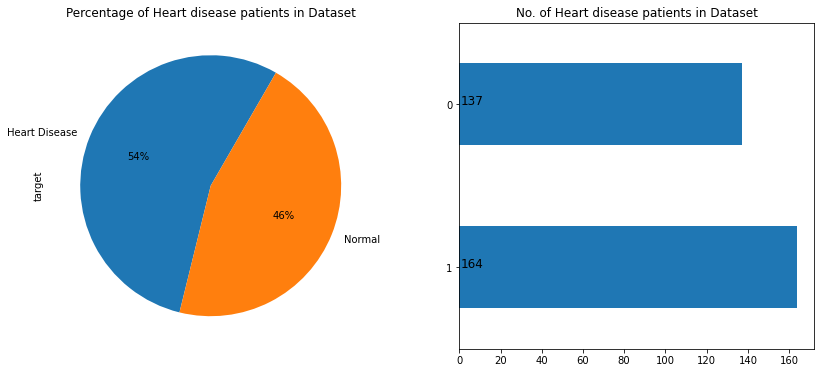

In [55]:
# Distribution of Heart disease (target variable)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14,6))

ax1 = dt['target'].value_counts().plot.pie( x="Heart disease" ,y ='no.of patients', 
                   autopct = "%1.0f%%",labels=["Heart Disease","Normal"], startangle = 60,ax=ax1);
ax1.set(title = 'Percentage of Heart disease patients in Dataset')

ax2 = dt["target"].value_counts().plot(kind="barh" ,ax =ax2)
for i,j in enumerate(dt["target"].value_counts().values):
    ax2.text(.5,i,j,fontsize=12)
ax2.set(title = 'No. of Heart disease patients in Dataset')
plt.show()

In [56]:
countNoDisease = len(dt[dt.target == 0])
countHaveDisease = len(dt[dt.target == 1])
print("Percentage of Patients Haven't Heart Disease: {:.2f}%".format((countNoDisease / (len(dt.target))*100)))
print("Percentage of Patients Have Heart Disease: {:.2f}%".format((countHaveDisease / (len(dt.target))*100)))

Percentage of Patients Haven't Heart Disease: 45.51%
Percentage of Patients Have Heart Disease: 54.49%


In [57]:
dt.groupby('target').mean()

age  resting_blood_pressure  cholesterol  \
target                                                   
0       56.635036              134.445255   251.430657   
1       52.493902              129.310976   242.390244   

        max_heart_rate_achieved  st_depression  major vessels  sex_female  \
target                                                                      
0                    138.978102       1.589781       1.175182    0.175182   
1                    158.731707       0.586585       0.365854    0.432927   

        sex_male  chest_pain_type_asymptomatic  \
target                                           
0       0.824818                      0.051095   
1       0.567073                      0.097561   

        chest_pain_type_atypical angina  ...  \
target                                   ...   
0                              0.065693  ...   
1                              0.250000  ...   

        rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
target                                                           
0                                    0.021898         0.576642   
1                                    0.006098         0.408537   

        exercise_induced_angina_no  exercise_induced_angina_yes  \
target                                                            
0                         0.452555                     0.547445   
1                         0.859756                     0.140244   

        st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
target                                                            
0                   0.255474       0.656934            0.087591   
1                   0.646341       0.298780            0.054878   

        thalassemia_fixed defect  thalassemia_normal  \
target                                                 
0                       0.262774            0.087591   
1                       0.792683            0.036585   

        thalassemia_reversable defect  
target                                 
0                            0.649635  
1                            0.170732  

[2 rows x 25 columns]

In [58]:
X = dt.drop(['target'],axis=1)
y = dt['target']
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)
# checking the shape of dataset
X.shape

(301, 25)

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.head(10)

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
58   0.111111                0.226415     0.117783                 0.786260   
51   0.822222                0.245283     0.394919                 0.610687   
260  0.822222                0.792453     0.224018                 0.717557   
288  0.622222                0.150943     0.471132                 0.549618   
200  0.333333                0.150943     0.152425                 0.809160   
50   0.488889                0.339623     0.288684                 0.595420   
266  0.577778                0.811321     0.452656                 0.351145   
280  0.288889                0.396226     0.424942                 0.412214   
236  0.644444                0.292453     0.390300                 0.763359   
7    0.333333                0.245283     0.304850                 0.778626   

     st_depression  major vessels  sex_female  sex_male  \
58        0.000000              0           0         1   
51        0.064516              0           0         1   
260       0.161290              2           1         0   
288       0.483871              1           0         1   
200       0.000000              1           0         1   
50        0.080645              0           1         0   
266       0.548387              0           1         0   
280       0.290323              0           0         1   
236       0.000000              2           0         1   
7         0.000000              0           0         1   

     chest_pain_type_asymptomatic  chest_pain_type_atypical angina  ...  \
58                              1                                0  ...   
51                              0                                0  ...   
260                             0                                0  ...   
288                             0                                0  ...   
200                             0                                0  ...   
50                              0                                0  ...   
266                             0                                0  ...   
280                             0                                0  ...   
236                             0                                0  ...   
7                               0                                1  ...   

     rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
58                                       0                1   
51                                       0                1   
260                                      0                0   
288                                      0                0   
200                                      0                1   
50                                       0                1   
266                                      1                0   
280                                      0                0   
236                                      0                1   
7                                        0                0   

     exercise_induced_angina_no  exercise_induced_angina_yes  \
58                            1                            0   
51                            1                            0   
260                           0                            1   
288                           0                            1   
200                           1                            0   
50                            1                            0   
266                           0                            1   
280                           0                            1   
236                           1                            0   
7                             1                            0   

     st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
58                      1              0                   0   
51                      0              1                   0   
260                     0              1                   0   
288      

In [60]:
X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.transform(X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
60   0.933333                0.150943     0.309469                 0.450382   
245  0.422222                0.283019     0.330254                 0.725191   
271  0.711111                0.377358     0.237875                 0.564885   
115  0.177778                0.245283     0.193995                 0.755725   
192  0.555556                0.245283     0.131640                 0.320611   

     st_depression  major vessels  sex_female  sex_male  \
60        0.000000              1           1         0   
245       0.080645              0           0         1   
271       0.419355              2           0         1   
115       0.000000              0           1         0   
192       0.225806              1           0         1   

     chest_pain_type_asymptomatic  chest_pain_type_atypical angina  ...  \
60                              0                                0  ...   
245                             0                                0  ...   
271                             1                                0  ...   
115                             0                                0  ...   
192                             0                                0  ...   

     rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
60                                       0                1   
245                                      0                1   
271                                      0                0   
115                                      0                0   
192                                      0                0   

     exercise_induced_angina_no  exercise_induced_angina_yes  \
60                            1                            0   
245                           1                            0   
271                           1                            0   
115                           1                            0   
192                           1                            0   

     st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
60                      1              0                   0   
245                     0              1                   0   
271                     0              1                   0   
115                     1              0                   0   
192                     0              1                   0   

     thalassemia_fixed defect  thalassemia_normal  \
60                          1                   0   
245                         0                   0   
271                         1                   0   
115                         1                   0   
192                         0                   0   

     thalassemia_reversable defect  
60                               0  
245                              1  
271                              0  
115                              0  
192                              1  

[5 rows x 25 columns]

In [61]:
logit = LogisticRegression(random_state = 0)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
roc=roc_auc_score(y_test, y_pred)
accuracies = cross_val_score(estimator = logit, X = X_test, y = y_test, cv = 10)
acc = accuracies.mean()
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results = pd.DataFrame([['Base - Logistic Regression', acc,prec,rec, f1,roc]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

results

Model  Accuracy  Precision    Recall  F1 Score  \
0  Base - Logistic Regression  0.802381   0.878788  0.878788  0.878788   

        ROC  
0  0.867965

In [62]:
# random_forest = RandomForestClassifier(n_estimators=500,criterion='entropy',max_depth=5).fit(X_train, y_train)
# random_forest = RandomForestClassifier().fit(X_train, y_train)
random_forest = RandomForestClassifier(max_depth=5).fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Model evaluation
roc=roc_auc_score(y_test, y_pred)
accuracies = cross_val_score(estimator = random_forest, X = X_test, y = y_test, cv = 10)
acc = accuracies.mean()
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results = results.append(model_results,sort=True)
results

Accuracy  F1 Score                       Model  Precision       ROC  \
0  0.802381  0.878788  Base - Logistic Regression   0.878788  0.867965   
0  0.819048  0.848485               Random Forest   0.848485  0.834957   

     Recall  
0  0.878788  
0  0.848485

In [63]:
# Feature Importance

# Native methods --> global importance measures
#  i.e they answer the question 'On average, how important is feature  i  for making a prediction'.

# Both random forests and logistic regression have native methods of formulating the relative importance of features.

# Decision trees come with a method for measuring the importance of a feature which works by adding up the total decrease 
# in the gini coefficient from nodes that depend on that feature. For a random forest, we can average this value across 
# all trees to get an estimate of festure importance. This is called the mean decrease in gini.

# For logistic regression, the importances of a feature is just given by the absolute value of its weight. Note that this is 
# only true since we have standardised the variables. Of course the weights themselves have a straightforward interpretation 
# in terms of how the associated feature affects the predicted outcome. 

print('Random Forest:')
display(eli5.show_weights(random_forest, feature_names =X_test.columns.tolist()))
print('Logistic Regression:')
display(eli5.show_weights(logit, feature_names =X_test.columns.tolist()))

Random Forest:


Logistic Regression:


In [64]:
# Feature Importance Native methods comment 

# One thing that both methods have in common is that they examine which features play the biggest role in fitting to the 
# training set, not which features are most useful for generalisation. If we want to know which risk factors are the most 
# impactful on one's chance of developing heart disease, it is really this second kind of feature importance that we want

# There are other drawbacks that are specific to each model:

# Random forest:
# Mean decrease in gini tends to overestimate the importance of continuous and high cardinality categorical data.
# It also underestimates the importance of highly correlated features.

# Logistic regression:
# By its nature, logistic regression can only model linear relationships between the features and target, and this obviously 
# limits its ability to demonstrate the importance of features which have a non-linear effect on the target.

# The primary advantage of both is that they are trivial to compute once you have fitted the model.

In [65]:
# 1. Permutation Importance

# One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions
# This concept is called feature importance.

# Permutation importance is calculated after a model has been fitted. 

# we will ask the following question: If I randomly shuffle a single column of the validation data, 
# leaving the target and all other columns in place, how would that affect the accuracy of predictions 
# in that now-shuffled data?
# Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds 
# to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on 
# heavily for predictions. 
print('Permutation Importance')
random_forest = RandomForestClassifier().fit(X_train, y_train)
perm = PermutationImportance(random_forest, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist(),top=24)

Permutation Importance


In [66]:
eli5.show_prediction(random_forest, X_test.iloc[10], feature_names=X_test.columns.tolist(), show_feature_values=True)

In [67]:
eli5.show_prediction(random_forest, X_test.iloc[42], feature_names=X_test.columns.tolist(), show_feature_values=True)

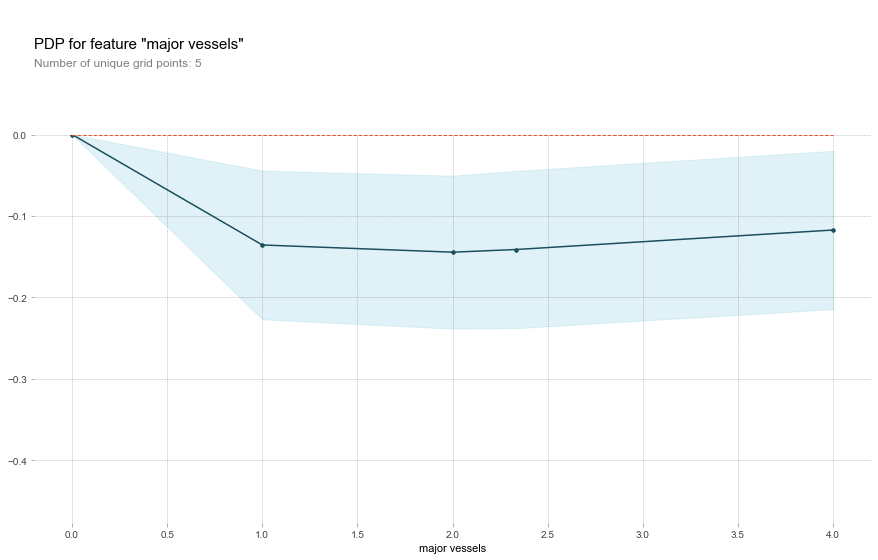

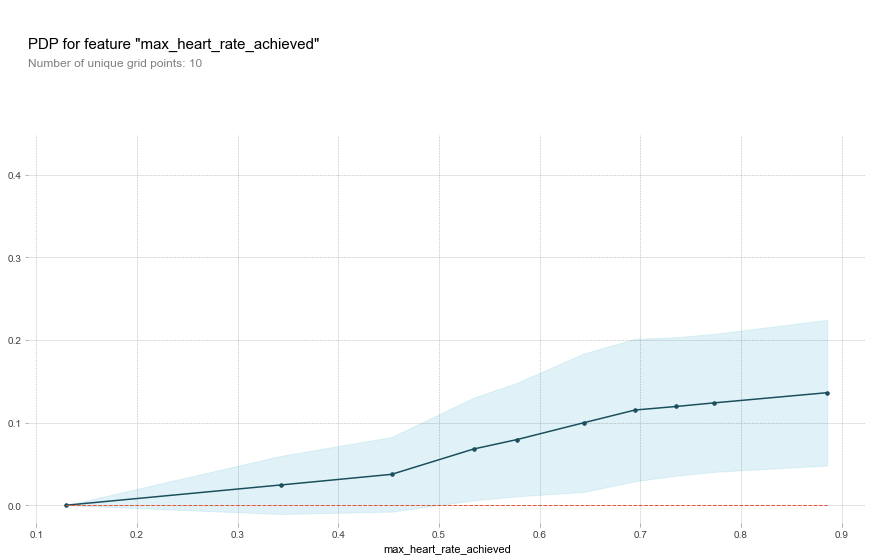

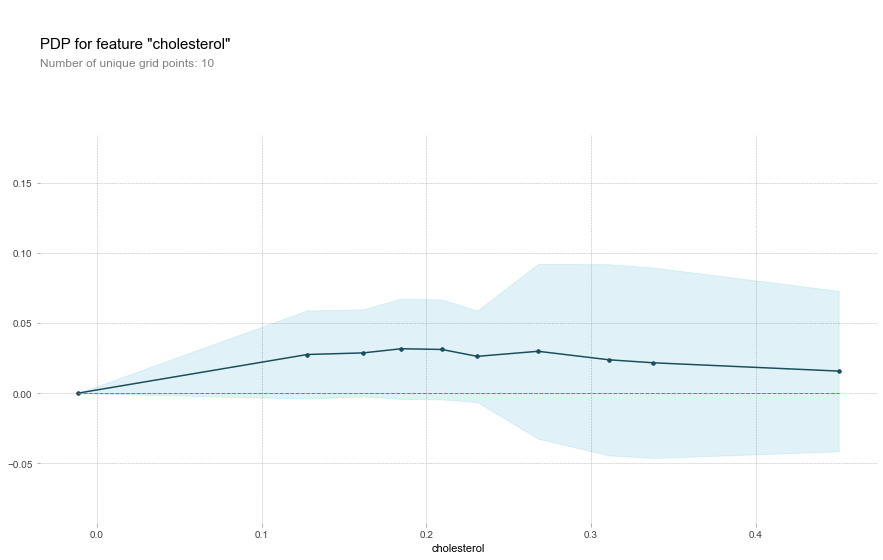

In [68]:
# 2. Partial Dependence Plots

# While feature importance shows what variables most affect predictions, partial dependence plots show how a feature 
# affects predictions.

# How it Works:
# Like permutation importance, partial dependence plots are calculated after a model has been fit. 
# The model is fit on real data that has not been artificially manipulated in any way.

# A few items are worth pointing out as you interpret this plot

# The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
# A blue shaded area indicates level of confidence

base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'major vessels'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
# comment : 
# So, we can see that as the number of major blood vessels increases, the probability of heart disease decreases. That makes 
# sense, as it means more blood can get to the heart.

feat_name = 'max_heart_rate_achieved'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
# comment : 
# So, we can see when max_heart_rate_achieved increases, the probability of heart disease increases. That makes sense

feat_name = 'cholesterol'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
# comment : 
# So, we can see when cholesterol increases, the probability of heart disease increases. That makes 
# sense,because high cholesterol increases the risk of cardiovascular disease due to a) an increase in blood pressure and 
# b) the extra load that the heart has to face.


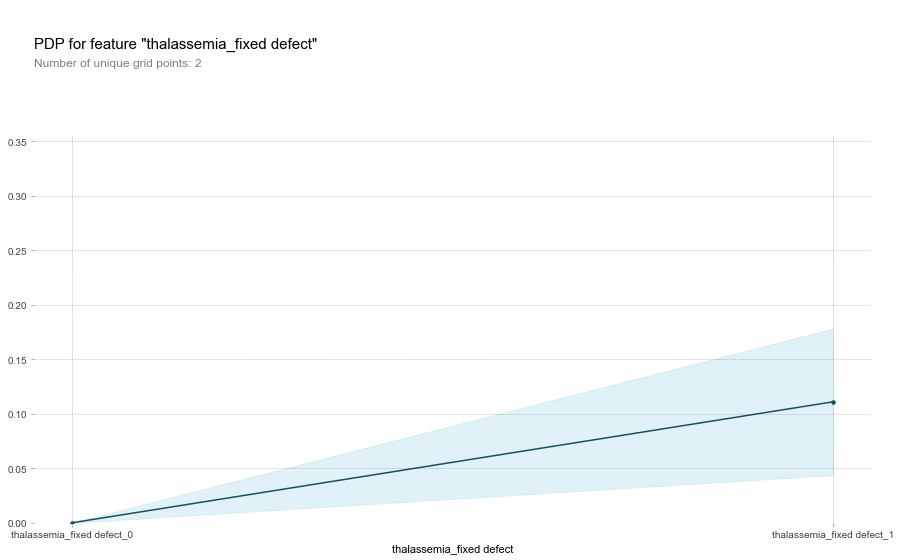

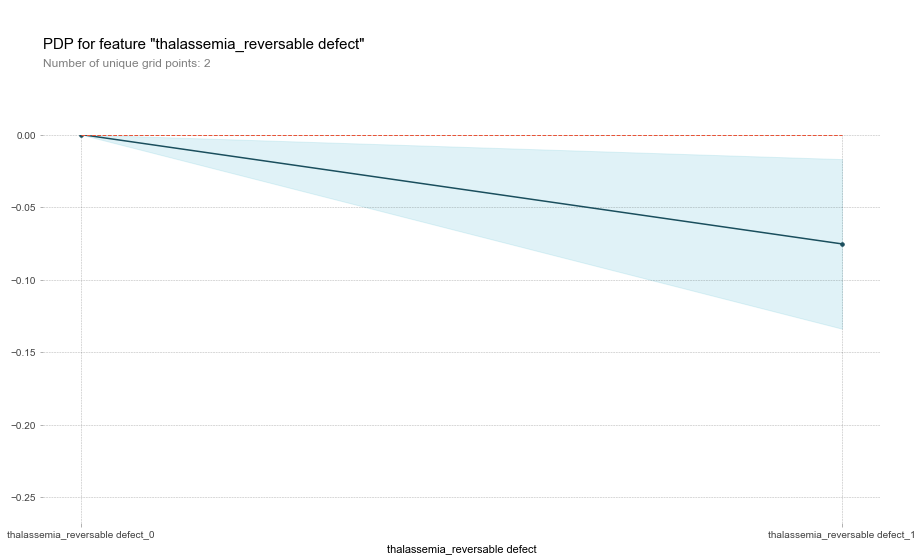

In [69]:
feat_name = 'thalassemia_fixed defect'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
# comment : 
# So, we can see when thalassemia_fixed defect increases, the probability of heart disease increases. That makes sense

feat_name = 'thalassemia_reversable defect'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
# comment : 
# So, we can see when thalassemia_fixed defec increases, the probability of heart disease decreases. That makes sense

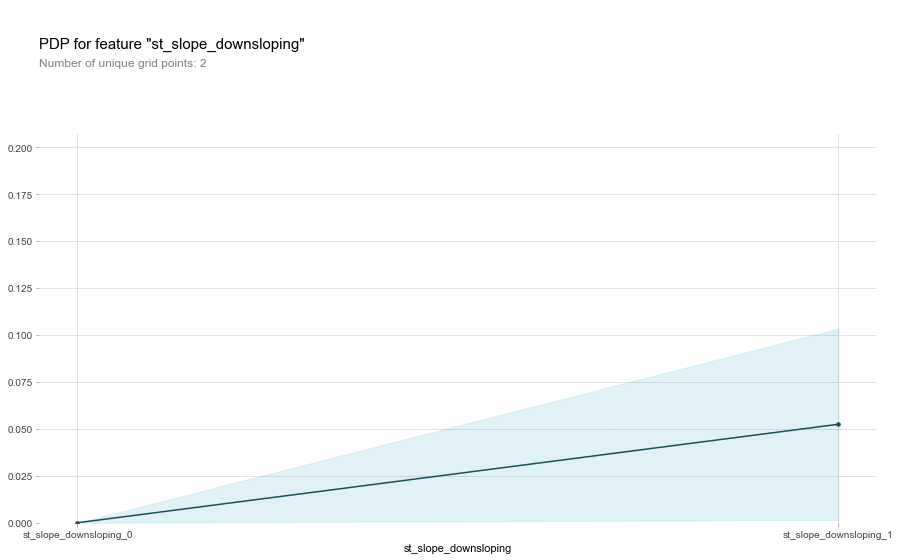

In [70]:
feat_name = 'st_slope_downsloping'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
# comment : 
# So, we can see when st_slope_downsloping increases, the probability of heart disease increases. That makes sense
# Upward or downward shifts can represent decreased blood flow to the heart from a variety of causes, including heart attack

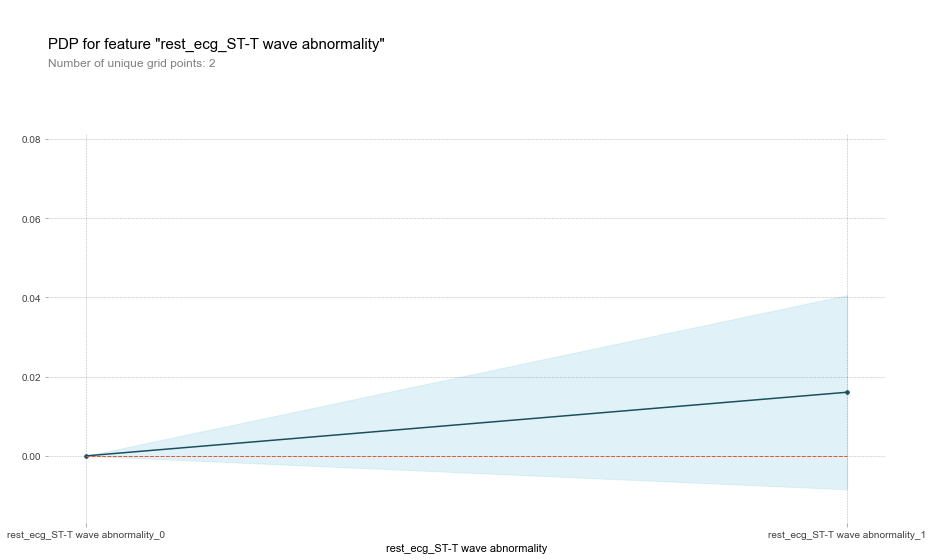

In [71]:
feat_name = 'rest_ecg_ST-T wave abnormality'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
# comment : 
# So, we can see when rest_ecg_ST-T wave abnormality increases, the probability of heart disease increases. That makes sense

In [72]:
# All base_features Partial Dependence Plots (PDP):
# base_features = dt.columns.values.tolist()
# base_features.remove('target')
# for feat_name in base_features:
#     pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
#     pdp.pdp_plot(pdp_dist, feat_name)
#     plt.show()

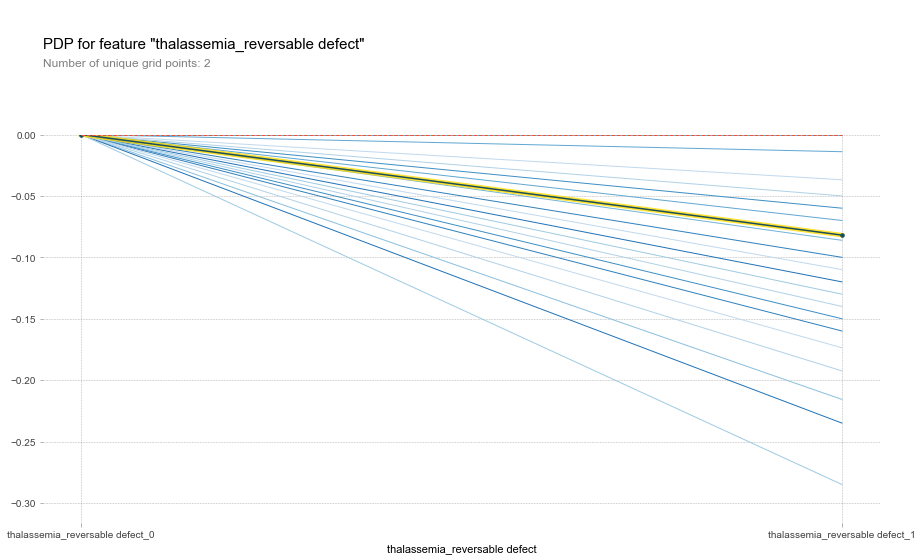

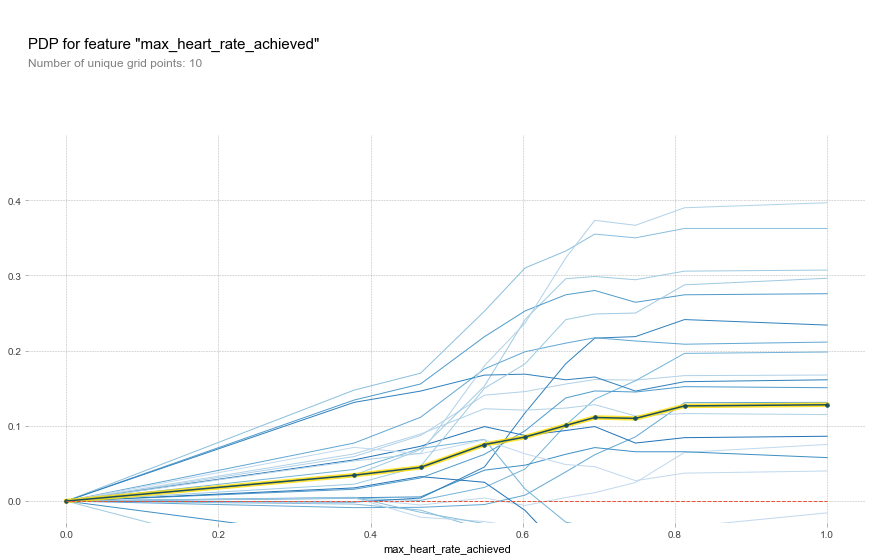

In [73]:
# ICE plots are similar to PD plots but offer a more detailed view about the behavior of near similar clusters around the 
# PD plot average curve. ICE algorithm gives the user insight into the several variants of conditional relationships 
# estimated by the black box.

def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()
    
plot_pdp(random_forest, X_train, 'thalassemia_reversable defect', cluster_flag=True, nb_clusters=24, lines_flag=True)
plot_pdp(random_forest, X_train, 'max_heart_rate_achieved', cluster_flag=True, nb_clusters=24, lines_flag=True)

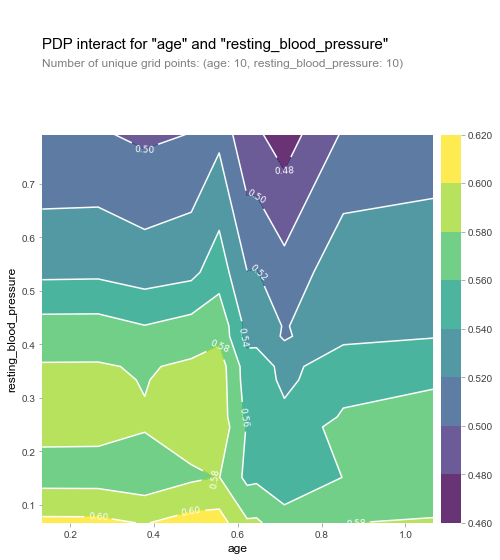

In [74]:
# 2D Partial Dependence Plots

inter1  =  pdp.pdp_interact(model=random_forest, dataset=X_test, model_features=base_features, features=['age', 'resting_blood_pressure'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['age', 'resting_blood_pressure'], plot_type='contour')
plt.show()

# comment : 
# As shown in figure above as age increases resting blood pressure also increases and at the point where normalized 
# age is around 0.7 and resting blood pressure is greater than 0.8 the chances for heart disease prediction is highest.

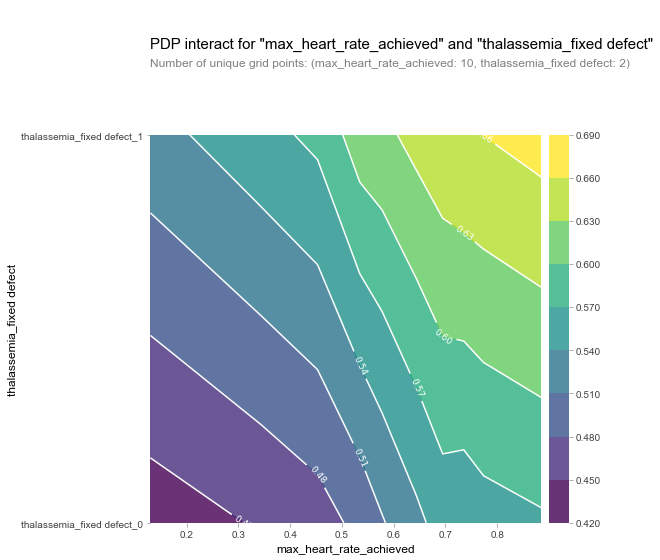

In [75]:
# 2D Partial Dependence Plots

inter1  =  pdp.pdp_interact(model=random_forest, dataset=X_test, model_features=base_features, features=['max_heart_rate_achieved', 'thalassemia_fixed defect'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['max_heart_rate_achieved', 'thalassemia_fixed defect'], plot_type='contour')
plt.show()

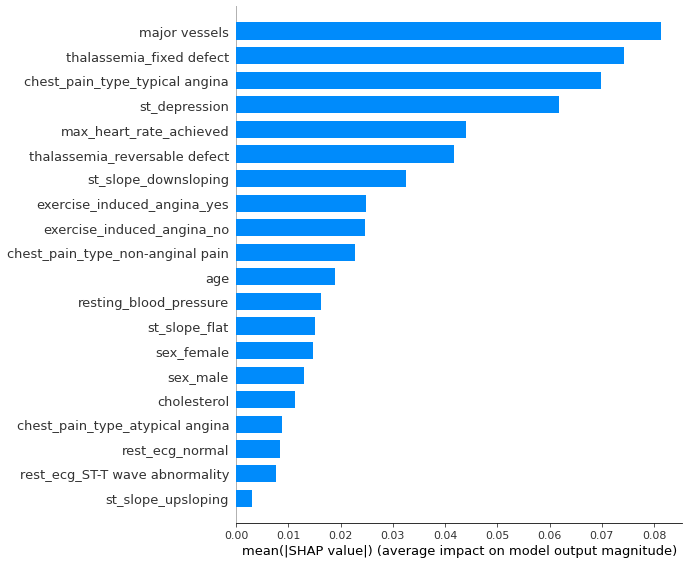

In [76]:
# 3. SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction.

# Shapley values are an idea that comes from game theory. For an input vector  x , to compute the Shapley value of feature  i , 
# we consider all the possible subset of features that don't include  i , and see how that model prediction would change if we 
# included  i . We then average of all such possible subsets. There are many theoretical properties of Shaply values which make 
# them attractive. In particular, they are the only measure of feature importance which satisfy the following four properties 
# simultaneously (we state these informally) :
# 1.Efficiency: The Shapley values of all features for a given prediction sum to the output of the model (i.e. the probability that target = 1).
# 2.Symmetry: Any two features which have the same effect on the prediction are given the same Shapley value.
# 3.Linearity: The Shapley value of a collection of features is the sum of the Shapley values of the features.
# 4.Dummy: A feature which has no effect on the prediction has a Shapley value of 0.

# We only compute the shap values for the random forest, and not logistic regression. There are a couple of reasons for this.
# TreeSHAP is a fast algorithm that comutes the exact Shapley values for the features and is unaffected by correlations 
# in the data. For logistic regression we would have to use the KernelSHAP algorithm, which is much slower, is affected 
# by correlations and only provides an approximation of the Shapley values.


# SHAP Feature Importance Plot
# comment : 
# The global mean(|Tree SHAP|) method applied to the heart disease prediction model. The x-axis is essentially 
# the average magnitude change in model output when a feature is “hidden” from the model 
# (for this model the output has log-odds units). 
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [77]:
# Let's see what the SHAP values tell us. These work by showing the influence of the values of every variable in a single row, 
# compared to their baseline values

# code for plotting Shapley values for individual prediction is shown below.
row_to_show = 20
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

random_forest.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(random_forest)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

# So how do we interpret this? First, we see that the base value is .46. This is the average probability that a patient has 
# heart disease for this dataset according to the model. 
# This diagram shows which features had the greatest influence in returning a probability of 0.93. 
# The features in red are applying a 'force' to increase the probability, and this force is proportional to their Shapley values. 
# Similarly, the features in blue decrease the probability. 


In [78]:
# So for this particular patient, the fact that he has (reversable defect) thalasemmia, st_depression, 
# and his chest_pain_type_typical angina are the major factors which increase the predicted probability that they have heart 
# disease, whereas the number of major vessels and the st_slope flat they have indicates that they are less 
# likely to have heart disease. This diagram is very good for visualising the importance of a feature for a 
# particular datapoint.
data_for_prediction

age                                          0.666667
resting_blood_pressure                       0.716981
cholesterol                                  0.450346
max_heart_rate_achieved                      0.526718
st_depression                                0.548387
major vessels                                0.000000
sex_female                                   0.000000
sex_male                                     1.000000
chest_pain_type_asymptomatic                 0.000000
chest_pain_type_atypical angina              0.000000
chest_pain_type_non-anginal pain             0.000000
chest_pain_type_typical angina               1.000000
fasting_blood_sugar_greater than 120mg/ml    0.000000
fasting_blood_sugar_lower than 120mg/ml      1.000000
rest_ecg_ST-T wave abnormality               0.000000
rest_ecg_left ventricular hypertrophy        0.000000
rest_ecg_normal                              1.000000
exercise_induced_angina_no                   0.000000
exercise_induced_angina_yes 

In [79]:
# Next, let's pick out individual patients and see how the different variables are affecting their outcomes,
row_to_show = 22
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

random_forest.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(random_forest)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

# Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature’s effect. 
# Feature values decreasing the prediction are in blue

In [80]:
data_for_prediction

age                                          0.400000
resting_blood_pressure                       0.132075
cholesterol                                  0.258661
max_heart_rate_achieved                      0.618321
st_depression                                0.000000
major vessels                                0.000000
sex_female                                   0.000000
sex_male                                     1.000000
chest_pain_type_asymptomatic                 0.000000
chest_pain_type_atypical angina              0.000000
chest_pain_type_non-anginal pain             1.000000
chest_pain_type_typical angina               0.000000
fasting_blood_sugar_greater than 120mg/ml    0.000000
fasting_blood_sugar_lower than 120mg/ml      1.000000
rest_ecg_ST-T wave abnormality               1.000000
rest_ecg_left ventricular hypertrophy        0.000000
rest_ecg_normal                              0.000000
exercise_induced_angina_no                   1.000000
exercise_induced_angina_yes 

In [81]:
# Next, let's pick out individual patients and see how the different variables are affecting their outcomes,
row_to_show = 23
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

random_forest.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(random_forest)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

# Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature’s effect. 
# Feature values decreasing the prediction are in blue

In [82]:
# Next, let's pick out individual patients and see how the different variables are affecting their outcomes,
row_to_show = 10
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

random_forest.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(random_forest)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

# Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature’s effect. 
# Feature values decreasing the prediction are in blue

In [83]:
# Next, let's pick out individual patients and see how the different variables are affecting their outcomes,
row_to_show = 9
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

random_forest.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(random_forest)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

# Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature’s effect. 
# Feature values decreasing the prediction are in blue

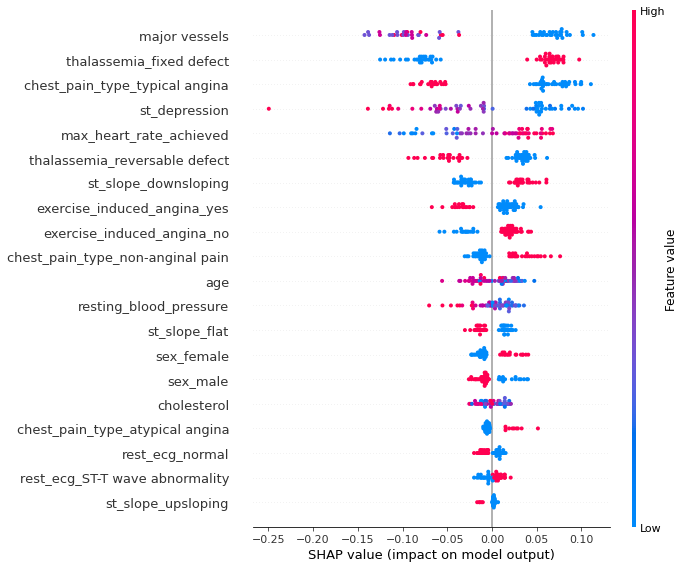

In [84]:
# SHAP Summary Plot
# To get an overview of which features are most important for a model we can plot the SHAP values of every feature 
# for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP 
# values to show the distribution of the impacts each feature has on the model output. The color represents the feature 
# value (red high, blue low).
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

# SHAP summary plot of a 20 feature Random Forest heart disease prediction. The higher the SHAP value of a feature, 
# the higher is the log odds of heart disease in this heart disease prediction model. Every patient in the dataset 
# is run through the model and a dot is created for each feature attribution value, so one patient gets one dot on 
# each feature’s line. Dot’s are colored by the feature’s value for that patient and pile up vertically to show density

# Higher values of thalasemia_fixed_defect increases the risk of heart disease whereas its lower
# values decreases the chances of heart disease.

# The number of major vessels division is pretty clear, and it's saying that low values are bad (blue on the right). 

# The thalassemia 'reversable defect' division is very clear (yes = red = good, no = blue = bad).

In [85]:
# 4. LIME(Local Interpretable Model-agnostic Explanations) **extra (https://towardsdatascience.com/whats-wrong-with-lime-86b335f34612)

# Local surrogate models are interpretable models that are used to explain individual 
# predictions of black box machine learning models.
# Surrogate models are trained to approximate the predictions of the underlying black box model. Instead of training 
# a global surrogate model, LIME focuses on training local surrogate models to explain individual predictions.

# The recipe for training local surrogate models:

# 1.Select your instance of interest for which you want to have an explanation of its black box prediction.
# 2.Perturb your dataset and get the black box predictions for these new points.
# 3.Weight the new samples according to their proximity to the instance of interest.
# 4.Train a weighted, interpretable model on the dataset with the variations.
# 5.Explain the prediction by interpreting the local model.
# Interpretable Machine Learning book : https://christophm.github.io/interpretable-ml-book/lime.html

In [86]:
import lime
import lime.lime_tabular
class_names=['Healthy','Disease']
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=base_features, class_names=class_names, discretize_continuous=True)
i = 19
print('Actual Label:', y_test[i])
print('Predicted Label:', y_pred[i])
exp = explainer.explain_instance(X_test.iloc[i].values, random_forest.predict_proba).show_in_notebook()

Actual Label: 1
Predicted Label: 1


In [87]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=base_features, class_names=class_names, discretize_continuous=True)
i = 55
print('Actual Label:', y_test[i])
print('Predicted Label:', y_pred[i])
exp = explainer.explain_instance(X_test.iloc[i].values, random_forest.predict_proba).show_in_notebook()

Actual Label: 1
Predicted Label: 1
